In [1]:
! pip install opencv-python

In [2]:
! pip install tqdm

In [3]:
import os
import requests, zipfile, io

import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
os.getcwd()

'/gpfs/global_fs01/sym_shared/YPProdSpark/user/s2a6-e3db73f3e93a34-883de94e7df9/notebook/work'

In [5]:
#url = requests.get('https://he-s3.s3.amazonaws.com/media/hackathon/deep-learning-challenge-1/identify-the-objects/a0409a00-8-dataset_dp.zip')
#data = zipfile.ZipFile(io.BytesIO(url.content))
#data.extractall()

In [6]:
os.listdir()

['sub_one.csv',
 'test_img',
 'train_img',
 'sample_submission.csv',
 'train.csv',
 'test.csv']

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
train.head()

,image_id,label
0,train_1a,rice
1,train_1b,candy
2,train_1c,jam
3,train_1d,coffee
4,train_2a,vinegar


In [9]:
print ('The train data has {} images.'.format(train.shape[0]))
print ('The test data has {} images.'.format(test.shape[0]))

The train data has 3215 images.
The test data has 1732 images.


In [10]:
print ('The train data has {} unique labels'.format(train['label'].nunique()))

The train data has 25 unique labels


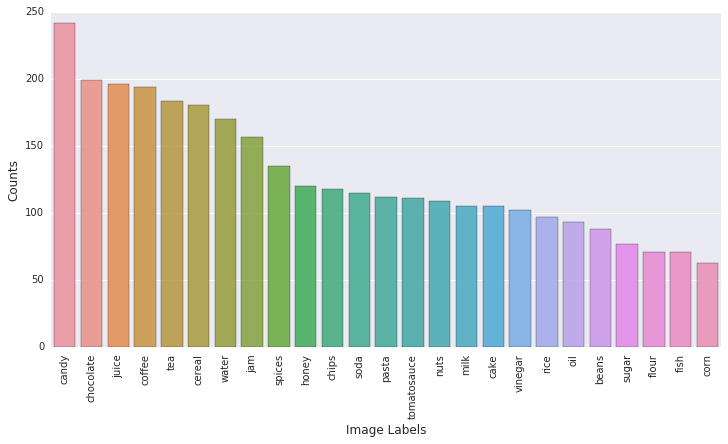

In [11]:
label_counts = train.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [12]:
TRAIN_PATH = 'train_img/'
TEST_PATH = 'test_img/'

In [13]:
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64))
    return img

In [14]:
train_data = []
test_data = []
train_labels = train['label'].values

for img in tqdm(train['image_id'].values):
    train_data.append(read_image(TRAIN_PATH + '{}.png'.format(img)))
    
for img in tqdm(test['image_id'].values):
    test_data.append(read_image(TEST_PATH + '{}.png'.format(img)))

100%|██████████| 1732/1732 [00:34<00:00, 49.65it/s]


In [15]:
x_train = np.array(train_data, np.float32) / 255.
x_test = np.array(test_data, np.float32) / 255.

In [16]:
label_list = train['label'].tolist()
Y_train = {k:v+1 for v,k in enumerate(set(label_list))}
y_train = [Y_train[k] for k in label_list]

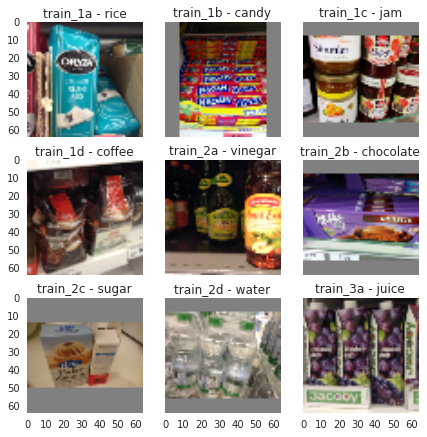

In [17]:
plt.rc('axes', grid=False)

_, axs = plt.subplots(3,3, sharex = 'col', sharey='row', figsize = (7,7))
axs = axs.ravel()

# lets see first 8 images - you can increase i value to see more images
for i, (image_name, label) in enumerate(zip(train.image_id, train.label)):
    if i <= 8:
        img = read_image(TRAIN_PATH + image_name + '.png')
        axs[i].imshow(img)
        axs[i].set_title('{} - {}'.format(image_name, label))
    else:
        break

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


In [19]:
y_train = to_categorical(y_train)

In [20]:
model = Sequential()
model.add(Convolution2D(32, (3,3), activation='relu', padding='same',input_shape = (64,64,3)))
model.add(Convolution2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
early_stops = EarlyStopping(patience=3, monitor='val_acc')

In [22]:
model.fit(x_train, y_train, batch_size=10, epochs=10, validation_split=0.3, callbacks=[early_stops])

Train on 2250 samples, validate on 965 samples
Epoch 1/10
2250/2250 [==============================] - 60s - loss: 3.1967 - acc: 0.0627 - val_loss: 3.1622 - val_acc: 0.0756
Epoch 2/10
2250/2250 [==============================] - 58s - loss: 3.1720 - acc: 0.0658 - val_loss: 3.1867 - val_acc: 0.0756
Epoch 3/10
2250/2250 [==============================] - 64s - loss: 3.1728 - acc: 0.0653 - val_loss: 3.1591 - val_acc: 0.0756
Epoch 4/10
2250/2250 [==============================] - 57s - loss: 3.1669 - acc: 0.0724 - val_loss: 3.1552 - val_acc: 0.0756
Epoch 5/10
2250/2250 [==============================] - 65s - loss: 3.1589 - acc: 0.0804 - val_loss: 3.0907 - val_acc: 0.0860
Epoch 6/10
2250/2250 [==============================] - 58s - loss: 3.0634 - acc: 0.1093 - val_loss: 2.9533 - val_acc: 0.1326
Epoch 7/10
2250/2250 [==============================] - 58s - loss: 2.9453 - acc: 0.1298 - val_loss: 2.9018 - val_acc: 0.1316
Epoch 8/10
2250/2250 [==============================] - 60s - loss: 2.8

In [23]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis= 1)

In [24]:
y_maps = dict()
y_maps = {v:k for k, v in Y_train.items()}
pred_labels = [y_maps[k] for k in predictions]

In [25]:
sub1 = pd.DataFrame({'image_id':test.image_id, 'label':pred_labels})
sub1.to_csv('sub_one.csv', index=False)

In [30]:
from IPython.display import HTML
import base64
def create_download_link( df, title = "Download CSV file", filename = "sub_one.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(sub1)  